# **Import , and Load Dataset**

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim 
import torch.functional as F
from torch.utils.data import Dataset, DataLoader
from nltk import word_tokenize , sent_tokenize , WordNetLemmatizer
from nltk.corpus import stopwords
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score ,  confusion_matrix

In [2]:
os.chdir("D:/NLP Text data")
print(os.listdir())

['BJT.txt', 'IMBD-Dataset-', 'IMDB Dataset.csv', 'Mosfet.txt', 'Solid state devices.txt', 'Transistor as amplifier.txt']


In [3]:
data = pd.read_csv('IMDB Dataset.csv')

# **preprocessing text**

In [4]:
def preprocessing(text) :
    punc = set(string.punctuation)
    stop_words = set(stopwords.words("english"))
    lemmatizer = WordNetLemmatizer()
    big_tokens = sent_tokenize(str(text))
    preprocessed = []
    for i in big_tokens :
        small_tokens = word_tokenize(i)
        filterd = [ lemmatizer.lemmatize(i.lower()) for i in small_tokens if ( i not in stop_words) and ( i not in punc) and (i.isdigit() == 0)]
        preprocessed.append(" ".join(filterd))
    return " ".join(preprocessed)
data["review_processed"] = data['review'].apply(preprocessing)
print(data.shape)

(50000, 3)


# **Convert Words to Numerical Sequences**

In [5]:
all_text = []
def alltext(text) :
    all_text.append(word_tokenize(text))
data['review_processed'].apply(alltext)

0        None
1        None
2        None
3        None
4        None
         ... 
49995    None
49996    None
49997    None
49998    None
49999    None
Name: review_processed, Length: 50000, dtype: object

In [7]:
all_text_words = []
for i in range(1,50001):
    all_text_words += all_text[i-1]
print("number of words in list datastructure :",len(all_text_words))
print("number of words in Set datastructure  :",len(set(all_text_words)))
print("this mean the list is larger than set with :",int(len(all_text_words)/len(set(all_text_words))),"scaler")

number of words in list datastructure : 7112983
number of words in Set datastructure  : 143309
this mean the list is larger than set with : 49 scaler


In [8]:
all_text_words = set(all_text_words)
numbers = [ i for i in range(len(all_text_words))]
word_to_idx = dict()
idx_to_word = dict()
for i , j in zip(all_text_words,numbers) :
    word_to_idx.update({i:j})
    idx_to_word.update({j:i})
print(len(word_to_idx))
print(len(idx_to_word))

143309
143309


In [9]:
def add_seqence(text) :
    tokenss = word_tokenize(text)
    converted = [ word_to_idx.get(i) for i in tokenss]
    return converted
data["sequence"] = data["review_processed"].apply(add_seqence)
print(data.iloc[:4,2:])

                                    review_processed  \
0  one reviewer mentioned watching oz episode 'll...   
1  a wonderful little production br br the filmin...   
2  i thought wonderful way spend time hot summer ...   
3  basically 's family little boy jake think 's z...   

                                            sequence  
0  [39109, 38102, 9962, 17889, 649, 9513, 88307, ...  
1  [132024, 44476, 75879, 38970, 70231, 70231, 66...  
2  [49497, 51849, 44476, 26893, 74470, 75144, 829...  
3  [70535, 141596, 44467, 75879, 88392, 65285, 13...  


# **Select fixed sequence lenght to train**

In [29]:
def pad_sequence(seq, seq_length=142):
    if len(seq) > seq_length:
        return seq[:seq_length]
    else:
        return seq + [0] * (seq_length - len(seq))
data["padded_sequence"] = data["sequence"].apply(pad_sequence)
x = np.array(data['padded_sequence'].tolist())
y = np.array(data['sentiment'].map({"positive": 1, "negative": 0}))
print(len(x))
print(len(y))

50000
50000


# **Train model phase**

In [83]:
class IMDBDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.int64)
        self.y = torch.tensor(y, dtype=torch.int64)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
train_dataset = IMDBDataset(X_train, y_train)
test_dataset = IMDBDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=10000, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2500, shuffle=False)

print("Training set size:", len(train_dataset))
print("Test set size:", len(test_dataset))

Training set size: 40000
Test set size: 10000


In [57]:
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size, num_layers):
        super(SentimentRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.rnn = nn.RNN(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        h0 = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

vocab_size = 143309 + 1
embed_size = 350
hidden_size = 128
output_size = 1
num_layers = 2
num_epochs = 100
learning_rate = 0.001
model = SentimentRNN(vocab_size, embed_size, hidden_size, output_size, num_layers)
criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
import tqdm
train_losses = []
train_accuracies = []
train_f1_scores = []
for epoch in range(num_epochs):
    epoch_losses = []
    epoch_accuracies = []
    epoch_f1s = []
    progress_bar = tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")  
    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(torch.int64), targets.to(torch.float32)
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        probs = torch.sigmoid(outputs)
        preds = (probs >= 0.5).float()
        accuracy = (preds == targets).float().mean().item()
        f1 = f1_score(targets.cpu().numpy(), preds.cpu().numpy(), zero_division=1)
        epoch_losses.append(loss.item())
        epoch_accuracies.append(accuracy)
        epoch_f1s.append(f1)
        progress_bar.set_postfix(loss=loss.item(), acc=accuracy, f1=f1)
    train_losses.append(sum(epoch_losses) / len(epoch_losses))
    train_accuracies.append(sum(epoch_accuracies) / len(epoch_accuracies))
    train_f1_scores.append(sum(epoch_f1s) / len(epoch_f1s))
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {train_losses[-1]:.4f}, Acc: {train_accuracies[-1]:.4f}, F1: {train_f1_scores[-1]:.4f}")


Epoch 1/100: 100%|██████████| 4/4 [15:05<00:00, 226.36s/it, acc=0.499, f1=0.248, loss=0.694]


Epoch [1/100] - Loss: 0.6948, Acc: 0.4990, F1: 0.4313


Epoch 2/100: 100%|██████████| 4/4 [15:49<00:00, 237.36s/it, acc=0.526, f1=0.283, loss=0.689]


Epoch [2/100] - Loss: 0.6894, Acc: 0.5238, F1: 0.2571


Epoch 3/100: 100%|██████████| 4/4 [13:06<00:00, 196.60s/it, acc=0.529, f1=0.643, loss=0.685]


Epoch [3/100] - Loss: 0.6858, Acc: 0.5328, F1: 0.6467


Epoch 4/100: 100%|██████████| 4/4 [12:59<00:00, 194.94s/it, acc=0.546, f1=0.302, loss=0.678]


Epoch [4/100] - Loss: 0.6804, Acc: 0.5415, F1: 0.3860


Epoch 5/100: 100%|██████████| 4/4 [10:29<00:00, 157.47s/it, acc=0.553, f1=0.658, loss=0.672]


Epoch [5/100] - Loss: 0.6730, Acc: 0.5528, F1: 0.5736


Epoch 6/100: 100%|██████████| 4/4 [00:59<00:00, 14.87s/it, acc=0.571, f1=0.673, loss=0.659]


Epoch [6/100] - Loss: 0.6635, Acc: 0.5649, F1: 0.4394


Epoch 7/100: 100%|██████████| 4/4 [00:56<00:00, 14.03s/it, acc=0.586, f1=0.678, loss=0.648]


Epoch [7/100] - Loss: 0.6544, Acc: 0.5781, F1: 0.6005


Epoch 8/100: 100%|██████████| 4/4 [00:57<00:00, 14.31s/it, acc=0.587, f1=0.682, loss=0.64] 


Epoch [8/100] - Loss: 0.6448, Acc: 0.5823, F1: 0.4554


Epoch 9/100: 100%|██████████| 4/4 [00:56<00:00, 14.16s/it, acc=0.596, f1=0.412, loss=0.63] 


Epoch [9/100] - Loss: 0.6333, Acc: 0.5885, F1: 0.5477


Epoch 10/100: 100%|██████████| 4/4 [00:55<00:00, 13.98s/it, acc=0.604, f1=0.701, loss=0.741]


Epoch [10/100] - Loss: 0.6872, Acc: 0.6114, F1: 0.6496


Epoch 11/100: 100%|██████████| 4/4 [00:56<00:00, 14.22s/it, acc=0.604, f1=0.694, loss=0.62] 


Epoch [11/100] - Loss: 0.6410, Acc: 0.6018, F1: 0.6937


Epoch 12/100: 100%|██████████| 4/4 [05:26<00:00, 81.72s/it, acc=0.605, f1=0.403, loss=0.618]


Epoch [12/100] - Loss: 0.6197, Acc: 0.6011, F1: 0.3974


Epoch 13/100: 100%|██████████| 4/4 [06:29<00:00, 97.41s/it, acc=0.609, f1=0.415, loss=0.612] 


Epoch [13/100] - Loss: 0.6165, Acc: 0.6059, F1: 0.4117


Epoch 14/100: 100%|██████████| 4/4 [04:31<00:00, 67.99s/it, acc=0.615, f1=0.428, loss=0.606]


Epoch [14/100] - Loss: 0.6068, Acc: 0.6136, F1: 0.4290


Epoch 15/100: 100%|██████████| 4/4 [02:36<00:00, 39.05s/it, acc=0.618, f1=0.442, loss=0.591]


Epoch [15/100] - Loss: 0.5941, Acc: 0.6217, F1: 0.4459


Epoch 16/100: 100%|██████████| 4/4 [01:28<00:00, 22.10s/it, acc=0.628, f1=0.473, loss=0.579]


Epoch [16/100] - Loss: 0.5809, Acc: 0.6282, F1: 0.4648


Epoch 17/100: 100%|██████████| 4/4 [01:06<00:00, 16.58s/it, acc=0.644, f1=0.724, loss=0.558]


Epoch [17/100] - Loss: 0.5675, Acc: 0.6357, F1: 0.7177


Epoch 18/100: 100%|██████████| 4/4 [01:03<00:00, 15.83s/it, acc=0.645, f1=0.729, loss=0.55] 


Epoch [18/100] - Loss: 0.5537, Acc: 0.6435, F1: 0.7254


Epoch 19/100: 100%|██████████| 4/4 [01:11<00:00, 17.87s/it, acc=0.648, f1=0.726, loss=0.538]


Epoch [19/100] - Loss: 0.5388, Acc: 0.6512, F1: 0.7301


Epoch 20/100: 100%|██████████| 4/4 [01:07<00:00, 16.90s/it, acc=0.656, f1=0.509, loss=0.523]


Epoch [20/100] - Loss: 0.5241, Acc: 0.6573, F1: 0.5148


Epoch 21/100: 100%|██████████| 4/4 [01:06<00:00, 16.62s/it, acc=0.663, f1=0.529, loss=0.506]


Epoch [21/100] - Loss: 0.5096, Acc: 0.6660, F1: 0.5245


Epoch 22/100: 100%|██████████| 4/4 [01:03<00:00, 15.84s/it, acc=0.673, f1=0.745, loss=0.494]


Epoch [22/100] - Loss: 0.4960, Acc: 0.6721, F1: 0.6485


Epoch 23/100: 100%|██████████| 4/4 [00:58<00:00, 14.58s/it, acc=0.675, f1=0.744, loss=0.479]


Epoch [23/100] - Loss: 0.4833, Acc: 0.6788, F1: 0.7487


Epoch 24/100: 100%|██████████| 4/4 [00:57<00:00, 14.33s/it, acc=0.688, f1=0.563, loss=0.469]


Epoch [24/100] - Loss: 0.4724, Acc: 0.6812, F1: 0.5602


Epoch 25/100: 100%|██████████| 4/4 [00:56<00:00, 14.03s/it, acc=0.688, f1=0.753, loss=0.461]


Epoch [25/100] - Loss: 0.4633, Acc: 0.6835, F1: 0.6671


Epoch 26/100: 100%|██████████| 4/4 [00:56<00:00, 14.22s/it, acc=0.68, f1=0.579, loss=0.455] 


Epoch [26/100] - Loss: 0.4556, Acc: 0.6868, F1: 0.6664


Epoch 27/100: 100%|██████████| 4/4 [00:57<00:00, 14.28s/it, acc=0.694, f1=0.75, loss=0.448] 


Epoch [27/100] - Loss: 0.4500, Acc: 0.6907, F1: 0.7100


Epoch 28/100: 100%|██████████| 4/4 [00:56<00:00, 14.19s/it, acc=0.702, f1=0.755, loss=0.443]


Epoch [28/100] - Loss: 0.4450, Acc: 0.6925, F1: 0.6240


Epoch 29/100: 100%|██████████| 4/4 [00:55<00:00, 13.92s/it, acc=0.692, f1=0.584, loss=0.444]


Epoch [29/100] - Loss: 0.4430, Acc: 0.6950, F1: 0.6727


Epoch 30/100: 100%|██████████| 4/4 [00:56<00:00, 14.07s/it, acc=0.695, f1=0.571, loss=0.441]


Epoch [30/100] - Loss: 0.4391, Acc: 0.6918, F1: 0.6305


Epoch 31/100: 100%|██████████| 4/4 [00:56<00:00, 14.17s/it, acc=0.698, f1=0.765, loss=0.442]


Epoch [31/100] - Loss: 0.4355, Acc: 0.6987, F1: 0.6842


Epoch 32/100: 100%|██████████| 4/4 [00:56<00:00, 14.11s/it, acc=0.698, f1=0.585, loss=0.438]


Epoch [32/100] - Loss: 0.4392, Acc: 0.6996, F1: 0.6746


Epoch 33/100: 100%|██████████| 4/4 [00:56<00:00, 14.01s/it, acc=0.695, f1=0.607, loss=0.432]


Epoch [33/100] - Loss: 0.4331, Acc: 0.6973, F1: 0.5862


Epoch 34/100: 100%|██████████| 4/4 [00:55<00:00, 13.93s/it, acc=0.705, f1=0.761, loss=0.429]


Epoch [34/100] - Loss: 0.4308, Acc: 0.7023, F1: 0.7615


Epoch 35/100: 100%|██████████| 4/4 [00:56<00:00, 14.06s/it, acc=0.689, f1=0.66, loss=0.427] 


Epoch [35/100] - Loss: 0.4274, Acc: 0.7014, F1: 0.7355


Epoch 36/100: 100%|██████████| 4/4 [00:57<00:00, 14.26s/it, acc=0.705, f1=0.627, loss=0.42] 


Epoch [36/100] - Loss: 0.4246, Acc: 0.7028, F1: 0.6155


Epoch 37/100: 100%|██████████| 4/4 [00:56<00:00, 14.07s/it, acc=0.707, f1=0.695, loss=0.425]


Epoch [37/100] - Loss: 0.4221, Acc: 0.7071, F1: 0.6433


Epoch 38/100: 100%|██████████| 4/4 [00:56<00:00, 14.08s/it, acc=0.706, f1=0.763, loss=0.422]


Epoch [38/100] - Loss: 0.4233, Acc: 0.7098, F1: 0.7467


Epoch 39/100: 100%|██████████| 4/4 [00:56<00:00, 14.20s/it, acc=0.719, f1=0.739, loss=0.418]


Epoch [39/100] - Loss: 0.4212, Acc: 0.7149, F1: 0.7564


Epoch 40/100: 100%|██████████| 4/4 [00:56<00:00, 14.01s/it, acc=0.693, f1=0.686, loss=0.471]


Epoch [40/100] - Loss: 0.4352, Acc: 0.7106, F1: 0.7140


Epoch 41/100: 100%|██████████| 4/4 [00:56<00:00, 14.24s/it, acc=0.684, f1=0.673, loss=0.466]


Epoch [41/100] - Loss: 0.4852, Acc: 0.6939, F1: 0.6715


Epoch 42/100: 100%|██████████| 4/4 [00:55<00:00, 13.84s/it, acc=0.681, f1=0.701, loss=0.485]


Epoch [42/100] - Loss: 0.4834, Acc: 0.6832, F1: 0.6766


Epoch 43/100: 100%|██████████| 4/4 [01:00<00:00, 15.09s/it, acc=0.691, f1=0.756, loss=0.452]


Epoch [43/100] - Loss: 0.4579, Acc: 0.6895, F1: 0.7480


Epoch 44/100: 100%|██████████| 4/4 [01:11<00:00, 17.96s/it, acc=0.688, f1=0.582, loss=0.445]


Epoch [44/100] - Loss: 0.4471, Acc: 0.6891, F1: 0.5864


Epoch 45/100: 100%|██████████| 4/4 [01:04<00:00, 16.09s/it, acc=0.701, f1=0.756, loss=0.441]


Epoch [45/100] - Loss: 0.4409, Acc: 0.6929, F1: 0.6689


Epoch 46/100: 100%|██████████| 4/4 [01:04<00:00, 16.07s/it, acc=0.699, f1=0.61, loss=0.428] 


Epoch [46/100] - Loss: 0.4359, Acc: 0.6990, F1: 0.7194


Epoch 47/100: 100%|██████████| 4/4 [01:04<00:00, 16.19s/it, acc=0.699, f1=0.755, loss=0.433]


Epoch [47/100] - Loss: 0.4313, Acc: 0.6982, F1: 0.6483


Epoch 48/100: 100%|██████████| 4/4 [01:11<00:00, 17.86s/it, acc=0.704, f1=0.606, loss=0.421]


Epoch [48/100] - Loss: 0.4258, Acc: 0.7037, F1: 0.6825


Epoch 49/100: 100%|██████████| 4/4 [01:05<00:00, 16.47s/it, acc=0.702, f1=0.759, loss=0.427]


Epoch [49/100] - Loss: 0.4219, Acc: 0.7066, F1: 0.7245


Epoch 50/100: 100%|██████████| 4/4 [01:01<00:00, 15.32s/it, acc=0.705, f1=0.61, loss=0.415] 


Epoch [50/100] - Loss: 0.4178, Acc: 0.7072, F1: 0.7000


Epoch 51/100: 100%|██████████| 4/4 [00:57<00:00, 14.30s/it, acc=0.713, f1=0.766, loss=0.414]


Epoch [51/100] - Loss: 0.4145, Acc: 0.7102, F1: 0.6572


Epoch 52/100: 100%|██████████| 4/4 [00:56<00:00, 14.03s/it, acc=0.716, f1=0.641, loss=0.408]


Epoch [52/100] - Loss: 0.4111, Acc: 0.7170, F1: 0.7354


Epoch 53/100: 100%|██████████| 4/4 [00:56<00:00, 14.14s/it, acc=0.732, f1=0.752, loss=0.411]


Epoch [53/100] - Loss: 0.4075, Acc: 0.7222, F1: 0.6815


Epoch 54/100: 100%|██████████| 4/4 [00:55<00:00, 13.91s/it, acc=0.725, f1=0.734, loss=0.405]


Epoch [54/100] - Loss: 0.4038, Acc: 0.7289, F1: 0.7423


Epoch 55/100: 100%|██████████| 4/4 [00:55<00:00, 13.94s/it, acc=0.733, f1=0.729, loss=0.399]


Epoch [55/100] - Loss: 0.4003, Acc: 0.7339, F1: 0.7391


Epoch 56/100: 100%|██████████| 4/4 [00:56<00:00, 14.07s/it, acc=0.742, f1=0.757, loss=0.396]


Epoch [56/100] - Loss: 0.3959, Acc: 0.7400, F1: 0.7348


Epoch 57/100: 100%|██████████| 4/4 [00:55<00:00, 13.86s/it, acc=0.752, f1=0.731, loss=0.39] 


Epoch [57/100] - Loss: 0.3914, Acc: 0.7482, F1: 0.7418


Epoch 58/100: 100%|██████████| 4/4 [00:55<00:00, 13.97s/it, acc=0.76, f1=0.765, loss=0.415] 


Epoch [58/100] - Loss: 0.4611, Acc: 0.7477, F1: 0.7546


Epoch 59/100: 100%|██████████| 4/4 [01:00<00:00, 15.02s/it, acc=0.721, f1=0.631, loss=0.409]


Epoch [59/100] - Loss: 0.4111, Acc: 0.7160, F1: 0.6261


Epoch 60/100: 100%|██████████| 4/4 [00:59<00:00, 14.80s/it, acc=0.725, f1=0.779, loss=0.413]


Epoch [60/100] - Loss: 0.4086, Acc: 0.7182, F1: 0.7407


Epoch 61/100: 100%|██████████| 4/4 [00:56<00:00, 14.15s/it, acc=0.722, f1=0.769, loss=0.412]


Epoch [61/100] - Loss: 0.4066, Acc: 0.7236, F1: 0.7746


Epoch 62/100: 100%|██████████| 4/4 [00:56<00:00, 14.04s/it, acc=0.718, f1=0.635, loss=0.401]


Epoch [62/100] - Loss: 0.4028, Acc: 0.7245, F1: 0.6807


Epoch 63/100: 100%|██████████| 4/4 [00:56<00:00, 14.23s/it, acc=0.73, f1=0.658, loss=0.391] 


Epoch [63/100] - Loss: 0.3994, Acc: 0.7199, F1: 0.6427


Epoch 64/100: 100%|██████████| 4/4 [00:55<00:00, 13.93s/it, acc=0.734, f1=0.769, loss=0.392]


Epoch [64/100] - Loss: 0.3953, Acc: 0.7326, F1: 0.7232


Epoch 65/100: 100%|██████████| 4/4 [00:55<00:00, 13.79s/it, acc=0.74, f1=0.78, loss=0.389]  


Epoch [65/100] - Loss: 0.3914, Acc: 0.7349, F1: 0.7765


Epoch 66/100: 100%|██████████| 4/4 [00:56<00:00, 14.11s/it, acc=0.746, f1=0.771, loss=0.383]


Epoch [66/100] - Loss: 0.3875, Acc: 0.7459, F1: 0.7752


Epoch 67/100: 100%|██████████| 4/4 [00:55<00:00, 13.95s/it, acc=0.729, f1=0.685, loss=0.388]


Epoch [67/100] - Loss: 0.3846, Acc: 0.7321, F1: 0.6954


Epoch 68/100: 100%|██████████| 4/4 [00:56<00:00, 14.02s/it, acc=0.738, f1=0.746, loss=0.386]


Epoch [68/100] - Loss: 0.3812, Acc: 0.7380, F1: 0.7122


Epoch 69/100: 100%|██████████| 4/4 [00:56<00:00, 14.23s/it, acc=0.749, f1=0.772, loss=0.381]


Epoch [69/100] - Loss: 0.3775, Acc: 0.7544, F1: 0.7767


Epoch 70/100: 100%|██████████| 4/4 [00:56<00:00, 14.23s/it, acc=0.757, f1=0.783, loss=0.373]


Epoch [70/100] - Loss: 0.3746, Acc: 0.7576, F1: 0.7827


Epoch 71/100: 100%|██████████| 4/4 [00:57<00:00, 14.35s/it, acc=0.751, f1=0.764, loss=0.377]


Epoch [71/100] - Loss: 0.3736, Acc: 0.7560, F1: 0.7701


Epoch 72/100: 100%|██████████| 4/4 [00:58<00:00, 14.54s/it, acc=0.754, f1=0.75, loss=0.373] 


Epoch [72/100] - Loss: 0.3780, Acc: 0.7502, F1: 0.7516


Epoch 73/100: 100%|██████████| 4/4 [00:57<00:00, 14.46s/it, acc=0.763, f1=0.777, loss=0.37] 


Epoch [73/100] - Loss: 0.3697, Acc: 0.7624, F1: 0.7686


Epoch 74/100: 100%|██████████| 4/4 [00:58<00:00, 14.71s/it, acc=0.774, f1=0.78, loss=0.363] 


Epoch [74/100] - Loss: 0.3621, Acc: 0.7722, F1: 0.7858


Epoch 75/100: 100%|██████████| 4/4 [00:58<00:00, 14.65s/it, acc=0.777, f1=0.785, loss=0.353]


Epoch [75/100] - Loss: 0.3571, Acc: 0.7749, F1: 0.7884


Epoch 76/100: 100%|██████████| 4/4 [00:59<00:00, 14.80s/it, acc=0.785, f1=0.796, loss=0.355]


Epoch [76/100] - Loss: 0.3514, Acc: 0.7823, F1: 0.7892


Epoch 77/100: 100%|██████████| 4/4 [01:00<00:00, 15.02s/it, acc=0.797, f1=0.805, loss=0.334]


Epoch [77/100] - Loss: 0.3416, Acc: 0.7899, F1: 0.7947


Epoch 78/100: 100%|██████████| 4/4 [01:02<00:00, 15.74s/it, acc=0.789, f1=0.805, loss=0.35] 


Epoch [78/100] - Loss: 0.3535, Acc: 0.7818, F1: 0.7957


Epoch 79/100: 100%|██████████| 4/4 [01:01<00:00, 15.49s/it, acc=0.778, f1=0.779, loss=0.379]


Epoch [79/100] - Loss: 0.3711, Acc: 0.7876, F1: 0.7934


Epoch 80/100: 100%|██████████| 4/4 [00:58<00:00, 14.75s/it, acc=0.757, f1=0.794, loss=0.401]


Epoch [80/100] - Loss: 0.4059, Acc: 0.7420, F1: 0.7855


Epoch 81/100: 100%|██████████| 4/4 [00:58<00:00, 14.67s/it, acc=0.699, f1=0.621, loss=0.429]


Epoch [81/100] - Loss: 0.4097, Acc: 0.7484, F1: 0.7225


Epoch 82/100: 100%|██████████| 4/4 [00:58<00:00, 14.62s/it, acc=0.689, f1=0.612, loss=0.429]


Epoch [82/100] - Loss: 0.4330, Acc: 0.6917, F1: 0.6089


Epoch 83/100: 100%|██████████| 4/4 [00:59<00:00, 14.94s/it, acc=0.704, f1=0.748, loss=0.425]


Epoch [83/100] - Loss: 0.4282, Acc: 0.6930, F1: 0.6569


Epoch 84/100: 100%|██████████| 4/4 [01:03<00:00, 15.99s/it, acc=0.7, f1=0.629, loss=0.419]  


Epoch [84/100] - Loss: 0.4240, Acc: 0.6985, F1: 0.6358


Epoch 85/100: 100%|██████████| 4/4 [01:09<00:00, 17.49s/it, acc=0.697, f1=0.604, loss=0.422]


Epoch [85/100] - Loss: 0.4186, Acc: 0.7023, F1: 0.6118


Epoch 86/100: 100%|██████████| 4/4 [01:14<00:00, 18.63s/it, acc=0.714, f1=0.762, loss=0.414]


Epoch [86/100] - Loss: 0.4151, Acc: 0.7056, F1: 0.6605


Epoch 87/100: 100%|██████████| 4/4 [01:17<00:00, 19.49s/it, acc=0.724, f1=0.77, loss=0.412] 


Epoch [87/100] - Loss: 0.4117, Acc: 0.7195, F1: 0.7688


Epoch 88/100: 100%|██████████| 4/4 [01:21<00:00, 20.36s/it, acc=0.712, f1=0.763, loss=0.406]


Epoch [88/100] - Loss: 0.4085, Acc: 0.7192, F1: 0.7678


Epoch 89/100: 100%|██████████| 4/4 [01:22<00:00, 20.69s/it, acc=0.718, f1=0.636, loss=0.403]


Epoch [89/100] - Loss: 0.4052, Acc: 0.7167, F1: 0.6731


Epoch 90/100: 100%|██████████| 4/4 [01:23<00:00, 20.77s/it, acc=0.71, f1=0.649, loss=0.398] 


Epoch [90/100] - Loss: 0.4017, Acc: 0.7125, F1: 0.6412


Epoch 91/100: 100%|██████████| 4/4 [01:13<00:00, 18.42s/it, acc=0.73, f1=0.771, loss=0.396] 


Epoch [91/100] - Loss: 0.3981, Acc: 0.7254, F1: 0.7610


Epoch 92/100: 100%|██████████| 4/4 [01:08<00:00, 17.16s/it, acc=0.716, f1=0.685, loss=0.393]


Epoch [92/100] - Loss: 0.3941, Acc: 0.7268, F1: 0.7392


Epoch 93/100: 100%|██████████| 4/4 [01:06<00:00, 16.66s/it, acc=0.724, f1=0.692, loss=0.388]


Epoch [93/100] - Loss: 0.3892, Acc: 0.7219, F1: 0.6817


Epoch 94/100: 100%|██████████| 4/4 [01:21<00:00, 20.44s/it, acc=0.735, f1=0.762, loss=0.383]


Epoch [94/100] - Loss: 0.3851, Acc: 0.7393, F1: 0.7595


Epoch 95/100: 100%|██████████| 4/4 [01:01<00:00, 15.40s/it, acc=0.737, f1=0.72, loss=0.377] 


Epoch [95/100] - Loss: 0.3795, Acc: 0.7383, F1: 0.7420


Epoch 96/100: 100%|██████████| 4/4 [01:00<00:00, 15.07s/it, acc=0.738, f1=0.758, loss=0.392]


Epoch [96/100] - Loss: 0.3855, Acc: 0.7367, F1: 0.7379


Epoch 97/100: 100%|██████████| 4/4 [00:57<00:00, 14.43s/it, acc=0.739, f1=0.769, loss=0.39] 


Epoch [97/100] - Loss: 0.3855, Acc: 0.7446, F1: 0.7740


Epoch 98/100: 100%|██████████| 4/4 [00:58<00:00, 14.51s/it, acc=0.769, f1=0.741, loss=0.36] 


Epoch [98/100] - Loss: 0.3810, Acc: 0.7433, F1: 0.7238


Epoch 99/100: 100%|██████████| 4/4 [00:57<00:00, 14.34s/it, acc=0.775, f1=0.797, loss=0.359]


Epoch [99/100] - Loss: 0.3659, Acc: 0.7706, F1: 0.7783


Epoch 100/100: 100%|██████████| 4/4 [00:57<00:00, 14.29s/it, acc=0.785, f1=0.794, loss=0.352]

Epoch [100/100] - Loss: 0.3550, Acc: 0.7702, F1: 0.7886


# **Train graphs**

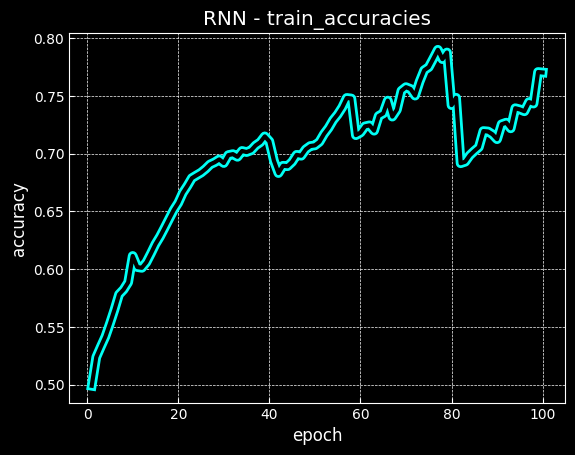

In [77]:
plt.style.use("dark_background")
plt.plot([ i for i in range(1,101)] , train_accuracies , color="#00fff4", linewidth=7)
plt.plot([ i for i in range(1,101)] , train_accuracies , color="black", linewidth=3)
plt.title("RNN - train_accuracies")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

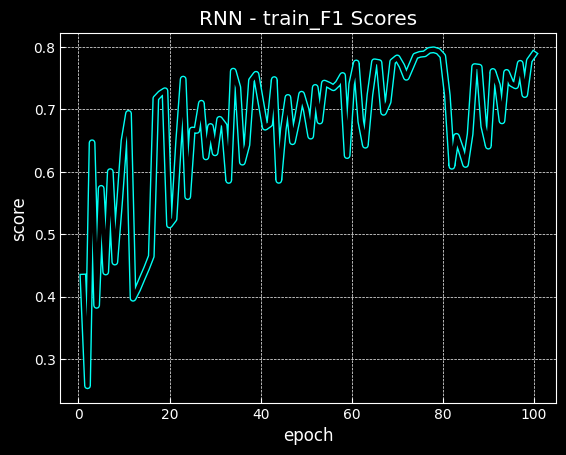

In [79]:
plt.style.use("dark_background")
plt.plot([ i for i in range(1,101)] , train_f1_scores , color="#00fff4", linewidth=5)
plt.plot([ i for i in range(1,101)] , train_f1_scores , color="black", linewidth=3)
plt.title("RNN - train_F1 Scores")
plt.xlabel("epoch")
plt.ylabel("score")
plt.show()

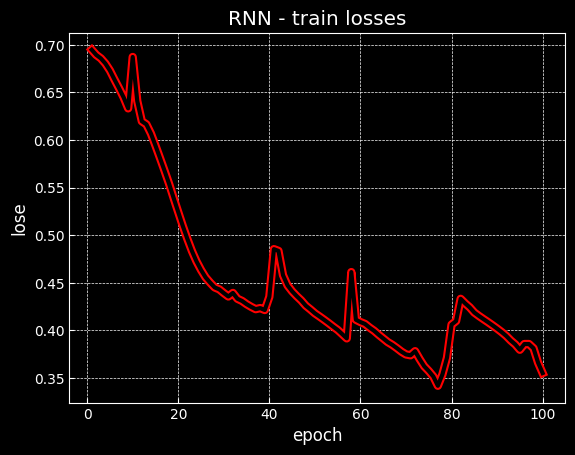

In [81]:
plt.style.use("dark_background")
plt.plot([ i for i in range(1,101)] , train_losses , color="red", linewidth=6)
plt.plot([ i for i in range(1,101)] , train_losses , color="black", linewidth=3)
plt.title("RNN - train losses")
plt.xlabel("epoch")
plt.ylabel("lose")
plt.show()

# **Test Data**

In [85]:
def evaluate(model, dataloader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(torch.int64), targets.to(torch.float32)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            probs = torch.sigmoid(outputs)
            preds = (probs >= 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            correct += (preds == targets).sum().item()
            total += targets.size(0)
    avg_loss = test_loss / len(dataloader)
    accuracy = correct / total
    f1 = f1_score(all_targets, all_preds, zero_division=1)
    print(f"Test Loss: {avg_loss:.4f}, Test Acc: {accuracy:.4f}, Test F1: {f1:.4f}")

evaluate(model, test_loader, criterion)

Test Loss: 1.4451, Test Acc: 0.5209, Test F1: 0.5383


Test Loss: 1.4451, Test Acc: 0.5209, Test F1: 0.5383


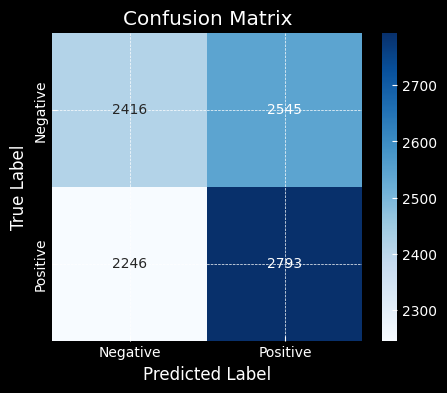

In [87]:
import seaborn as sns
def evaluate(model, dataloader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(torch.int64), targets.to(torch.float32)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            probs = torch.sigmoid(outputs)
            preds = (probs >= 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            correct += (preds == targets).sum().item()
            total += targets.size(0)
    avg_loss = test_loss / len(dataloader)
    accuracy = correct / total
    f1 = f1_score(all_targets, all_preds, zero_division=1)
    print(f"Test Loss: {avg_loss:.4f}, Test Acc: {accuracy:.4f}, Test F1: {f1:.4f}")
    return avg_loss, accuracy, f1, np.array(all_targets), np.array(all_preds)
test_loss, test_acc, test_f1, y_true, y_pred = evaluate(model, test_loader, criterion)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [88]:
torch.save(model.state_dict(), "model_weights_RNN.pth")